In [1]:
# !pip install matplotlib h5py python-Levenshtein
# !pip install --upgrade ipywidgets
# !pip install tqdm
# !pip install --upgrade ipywidgets jupyterlab jupyterlab-widgets

## Imports

In [2]:
import torch
from torch import nn
from torch.utils.data import Dataset, IterableDataset, DataLoader
from torch.utils.data._utils.collate import default_convert
import torch.nn.functional as F
from torch.nn import init
import torch.distributed as dist
import torch.optim as optim

import matplotlib.pyplot as plt
import itertools
import numpy as np
import pickle, h5py
import time
import random, os, re, collections

In [3]:
# !pip install jupyterlab-widgets
# !jupyter labextension enable @jupyter-widgets/jupyterlab-manager
# from tqdm import tqdm
# import ipywidgets

## Dataloader

In [4]:
# import pickle
# import os
# import h5py
# from torch.utils.data import Dataset, DataLoader

# class CustomPickleDataset(Dataset):
#     def __init__(self, tokens_file, sizes_file, folder_path, data_range, token_id_map=None, pad_length=12):
#         """
#         Args:
#             tokens_file (str): Path to the pickle file containing tokens.
#             sizes_file (str): Path to the pickle file containing sizes.
#             folder_path (str): Path to the folder containing HDF5 files.
#             token_id_map (dict): Mapping of tokens to IDs.
#             pad_length (int): Maximum length for padding tokens.
#         """
#         # Load tokens and sizes
#         with open(tokens_file, 'rb') as f:
#             self.tokens = pickle.load(f)
        
#         with open(sizes_file, 'rb') as f:
#             self.sizes = pickle.load(f)

#         # Preload all HDF5 data into memory
#         self.data = []
#         # self.token_id_map = token_id_map
#         self.pad_length = pad_length

#         def extract_number(file_path):
#             match = re.search(r'(\d+)', file_path)
#             return int(match.group(1)) if match else float('inf')

#         self.h5_files = sorted(
#             [os.path.join(folder_path, file) for file in os.listdir(folder_path) if file.endswith('.h5')],
#             key=extract_number
#         )[data_range[0]:data_range[1]]

#         # Load all chunks from all files into memory
#         for file_path in self.h5_files:
#             with h5py.File(file_path, 'r') as h5_file:
#                 file_data = h5_file['data']
#                 self.data.extend(file_data[:])  # Load all data from the file

        
#         # change length of tokens and sizes to keep lengths of variables consistent
#         self.tokens = self.tokens[:len(self.data)]
#         self.sizes = self.sizes[:len(self.data)]
        
#         # Validate data consistency
#         assert len(self.tokens) == len(self.sizes) == len(self.data), \
#             f"Mismatch in data lengths: tokens({len(self.tokens)}), sizes({len(self.sizes)}), data({len(self.data)})."

#     def __len__(self):
#         return len(self.tokens)
    
#     def __getitem__(self, idx):
#         # Get tokenized and padded tokens
#         # tokens = self.tokens[idx][0]
#         # tokens = [self.token_id_map[x] for x in tokens]
#         # tokens = tokens + [self.token_id_map["<PAD>"]] * (self.pad_length - len(tokens))
        
#         word = self.tokens[idx][1]  # Get the word
#         size = self.sizes[idx]      # Get the size
#         chunk = self.data[idx]      # Get the corresponding chunk
#         # return torch.tensor(tokens), word, torch.tensor(size), torch.tensor(chunk)
#         return word, torch.tensor(size), torch.tensor(chunk)

In [5]:
import pickle
import os
import h5py
import re # Make sure re is imported
import torch # Make sure torch is imported
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm # Keep tqdm for progress

class CustomPickleDataset(Dataset):
    def __init__(self, tokens_file, sizes_file, folder_path, data_range, token_id_map=None, pad_length=12):
        # Load full tokens and sizes first
        with open(tokens_file, 'rb') as f:
            all_tokens = pickle.load(f)
        with open(sizes_file, 'rb') as f:
            all_sizes = pickle.load(f)

        self.pad_length = pad_length

        def extract_number(file_path):
            # Robust extraction: handle potential missing numbers or different formats
            basename = os.path.basename(file_path)
            match = re.search(r'(\d+)', basename)
            return int(match.group(1)) if match else float('inf')

        all_h5_files_unsorted = [os.path.join(folder_path, file) for file in os.listdir(folder_path) if file.endswith('.h5')]
        # Check if sorting is actually needed based on filenames
        if not all_h5_files_unsorted:
             raise FileNotFoundError(f"No HDF5 files found in {folder_path}")

        # Sort based on extracted number
        all_h5_files_sorted = sorted(all_h5_files_unsorted, key=extract_number)

        # --- Determine the START and END item indices corresponding to the file range ---
        self.data = []
        start_item_index = 0
        end_item_index = 0
        items_loaded = 0
        files_in_range = all_h5_files_sorted[data_range[0]:data_range[1]]

        # Check if the selected range is valid
        if not files_in_range:
             print(f"Warning: Data range {data_range} resulted in empty file list from {len(all_h5_files_sorted)} total files.")
             # Handle this case: maybe raise error or result in empty dataset
             self.tokens = []
             self.sizes = []
             self.data = []
             return # Stop initialization

        print(f"Loading data from {len(files_in_range)} HDF5 files (indices {data_range[0]} to {data_range[1]-1})...")

        # Calculate start index by summing lengths of files *before* the range
        print("Calculating start index...")
        pbar_start = tqdm(total=data_range[0], desc="Calc Start Idx", leave=False)
        for i in range(data_range[0]):
            try:
                with h5py.File(all_h5_files_sorted[i], 'r') as h5_file:
                    start_item_index += len(h5_file['data'])
                    pbar_start.update(1)
            except Exception as e:
                 print(f"Warning: Could not read file {all_h5_files_sorted[i]} to determine length: {e}")
                 # Decide how to handle: skip? raise error? Assume zero length?
        pbar_start.close()

        print(f"Calculated start item index: {start_item_index}")

        # Load data from the selected files AND calculate end index
        print(f"Loading chunks from files in range {data_range}...")
        pbar_load = tqdm(files_in_range, desc="Loading Chunks", leave=False)
        for file_path in pbar_load:
            try:
                with h5py.File(file_path, 'r') as h5_file:
                    file_data_array = h5_file['data'][:] # Load into memory
                    self.data.extend(file_data_array)
                    items_loaded += len(file_data_array)
                    pbar_load.set_postfix({"File": os.path.basename(file_path), "Items": len(file_data_array)})
            except Exception as e:
                print(f"Warning: Could not read data from file {file_path}: {e}")
                # Decide how to handle: skip? raise error?

        pbar_load.close()
        end_item_index = start_item_index + items_loaded
        print(f"Finished loading {items_loaded} chunks. Total data length: {len(self.data)}")
        print(f"Calculated end item index: {end_item_index}")


        # --- Slice tokens and sizes using the calculated item indices ---
        if start_item_index >= len(all_tokens) or start_item_index >= len(all_sizes):
             print(f"Warning: Calculated start item index ({start_item_index}) is out of bounds for tokens/sizes (len {len(all_tokens)}/{len(all_sizes)}). Check file contents vs pickle files.")
             self.tokens = []
             self.sizes = []
             # Maybe truncate self.data too or raise error
             self.data = []
             return

        # Adjust end_item_index if it exceeds the bounds of the original lists
        safe_end_item_index = min(end_item_index, len(all_tokens), len(all_sizes))
        if safe_end_item_index < end_item_index:
             print(f"Warning: Calculated end item index ({end_item_index}) exceeds tokens/sizes list length. Truncating slice to {safe_end_item_index}.")
             # Also truncate self.data to match the number of items we can actually get labels/sizes for
             items_to_keep = safe_end_item_index - start_item_index
             if items_to_keep < len(self.data):
                  print(f"Truncating self.data from {len(self.data)} to {items_to_keep} items.")
                  self.data = self.data[:items_to_keep]


        print(f"Slicing tokens/sizes from index {start_item_index} to {safe_end_item_index}")
        self.tokens = all_tokens[start_item_index:safe_end_item_index]
        self.sizes = all_sizes[start_item_index:safe_end_item_index]

        # Final validation
        print(f"Final lengths: tokens={len(self.tokens)}, sizes={len(self.sizes)}, data={len(self.data)}")
        assert len(self.tokens) == len(self.sizes) == len(self.data), \
            f"CRITICAL: Mismatch after slicing: tokens({len(self.tokens)}), sizes({len(self.sizes)}), data({len(self.data)})."


    def __len__(self):
        # Return the length of the *loaded* data for this specific dataset instance
        return len(self.data) # Use self.data length as the source of truth after __init__

    def __getitem__(self, idx):
        # idx will now correctly correspond to the items in self.tokens, self.sizes, self.data
        if idx >= len(self.data):
             # This shouldn't happen if __len__ is correct, but good sanity check
             raise IndexError(f"Index {idx} out of bounds for dataset length {len(self.data)}")

        word = self.tokens[idx][1]  # Get the word
        size = self.sizes[idx]      # Get the size
        chunk = self.data[idx]      # Get the corresponding chunk

        # Ensure correct types are returned (DataLoader's collate_fn might handle some)
        # It's generally safer to convert to tensors here if not done by collate_fn
        # Returning raw types might be fine if default_collate handles it.
        # Let's assume default collate works for now based on your previous code.
        # Note: If 'chunk' is already a numpy array from HDF5, wrap it.
        # If size is a numpy type, wrap it.
        return word, torch.tensor(size), torch.from_numpy(chunk) if not isinstance(chunk, torch.Tensor) else chunk

# --- DataLoader Instantiation ---
# tokens_file = 'dataset/tokens.pkl'
# sizes_file = 'dataset/chunks_size_count.pkl'
# folder_path = 'dataset/ImageChunksSmallCollated/ImageChunksSmallCollated'

# print("loading training data")
# train_dataset = CustomPickleDataset(tokens_file, sizes_file, folder_path, pad_length=12, data_range=[0, 100]) # Starts at 0 - should be fine
# train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, pin_memory=False, num_workers=0) # Start with num_workers=0 for debug

# print("loading validation data")
# # Example: Load files corresponding to indices 100 to 120 (exclusive of 120)
# val_dataset = CustomPickleDataset(tokens_file, sizes_file, folder_path, pad_length=12, data_range=[100, 120])
# val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, pin_memory=False, num_workers=0) # NO SHUFFLE, num_workers=0

In [6]:
try:
    del train_dataset
    del train_loader
    del val_dataset
    del val_loader
except: pass

tokens_file = 'dataset/tokens.pkl'
sizes_file = 'dataset/chunks_size_count.pkl'
folder_path = 'dataset/ImageChunksSmallCollated/ImageChunksSmallCollated'

# print("loading training data")
# train_dataset = CustomPickleDataset(tokens_file, sizes_file, folder_path, pad_length=12, data_range=[0,900])
# train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, pin_memory=False)

print("loading validation data")
val_dataset = CustomPickleDataset(tokens_file, sizes_file, folder_path, pad_length=12, data_range=[900,1000])
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True, pin_memory=False)

loading validation data
Loading data from 100 HDF5 files (indices 900 to 999)...
Calculating start index...


Calculated start item index: 180000
Loading chunks from files in range [900, 1000]...


Finished loading 20000 chunks. Total data length: 20000
Calculated end item index: 200000
Slicing tokens/sizes from index 180000 to 200000
Final lengths: tokens=20000, sizes=20000, data=20000


Words: [('शलाकापुरुष', 'मिचली', 'बितावे', 'चिकनियापन', 'जूही', 'जनन', 'रंगदानी', 'पूगफल', 'भटकटैया', 'ढुलना', 'हेराते', 'ठगता', 'ज्ञापित', 'अललाए', 'लिखितता', 'उगटिए', 'घिसटते', 'सीमातिक्रमित', 'शंपात', 'अनिलसार', 'मालतीतीरज', 'कुरेलन', 'घबराएगी', 'घुमकर', 'उबहती', 'जुगल', 'मियादी', 'बाउल', 'लोन', 'गुमाएगी', 'अपरक्ति', 'चपकाइए', 'टारटन', 'परुसता', 'उगलने', 'जघनचपला', 'महकाते', 'खोलवाना', 'चढाव', 'चकोटता', 'जकडाव', 'मित्राई', 'चुदते', 'बुरादना', 'पैनाओ', 'पंचबाण', 'सुलाती', 'सैरो', 'बेलरूसियन', 'अटकल', 'शिकायती', 'आलसहीन', 'लहराया', 'लौटरी', 'जहीन', 'मोडतोड', 'सुरवाहन', 'उगाहने', 'कीनियाई', 'जलसंभर', 'लिलाम', 'बनिहाल', 'जीवंतक', 'बजवाओगी')]
Sizes: torch.Size([64])
Chunks: torch.Size([64, 11, 64, 64])
हेराते


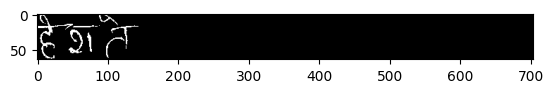

In [7]:
for batch in train_loader:
    # print(batch)
    words, sizes, chunks = batch
    print("Words:", words)
    print("Sizes:", sizes.shape)
    print("Chunks:", chunks.shape)  # Expect (batch_size, 11, 64, 64)
    break

import matplotlib.pyplot as plt
idxx = 10
print(words[0][idxx])
plt.imshow(np.hstack(chunks[idxx]), cmap="gray")

Words: [('अपच', 'सपे', 'इशा', 'मरूर', 'अमुख्यत', 'सिलबिलिया', 'ठनकावे', 'तानसेन', 'फबना', 'खनिजीय', 'बरछी', 'विशेषित', 'मूदाती', 'बिठाना', 'आखता', 'दूरंगम', 'कुटीचक', 'अकीदे', 'दौहित्रायण', 'कोमलीकरण', 'उलझाती', 'डेमोक्रेसी', 'बखारी', 'सरसेटने', 'पिता', 'निक्षारक', 'नकारवाता', 'क्रोडपत्रीय', 'वैट', 'झुमवाकर', 'बहुक्म', 'ओशीरिश', 'ग्रहनेमि', 'घासयुक्त', 'आविर', 'बउराते', 'संज्ञापद', 'जिदियाते', 'सुपरिभाषितता', 'तराशवाते', 'नडह', 'आये', 'सजाता', 'छेडने', 'अलते', 'नामचा', 'खटारा', 'विपद', 'पागलपना', 'फैलता', 'निखात', 'घनतोल', 'बखानेगा', 'बहुमत', 'अपरिभाषितता', 'अपाटवत', 'चिरायंद', 'परिसीमितता', 'साधुधी', 'क्रोडीय', 'खुदाई', 'नेवग', 'अग्रहरण', 'दूतसंवाद')]
Sizes: torch.Size([64])
Chunks: torch.Size([64, 11, 64, 64])
बरछी


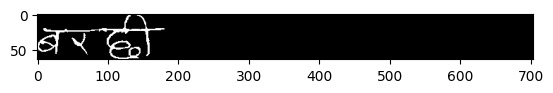

In [9]:
for batch in val_loader:
    # print(batch)
    words, sizes, chunks = batch
    print("Words:", words)
    print("Sizes:", sizes.shape)
    print("Chunks:", chunks.shape)  # Expect (batch_size, 11, 64, 64)
    break

import matplotlib.pyplot as plt
idxx = 10
print(words[0][idxx])
plt.imshow(np.hstack(chunks[idxx]), cmap="gray")

## Architecture

In [10]:
 # -ँंःअआइईउऊएऐओऔकखगघङचछजझञटठडढणतथदधनपफबभमयरलवशषसह़ािीुूृेैॉोौ्ज़ड़ढ़।०१२३४५६७८९
HINDI_ALPHABET = ("-ँंःअआइईउऊएऐओऔकखगघङचछजझञटठडढणतथदधनपफबभमयरलवशषसह़ािीुूृेैॉोौ्ज़ड़ढ़।०१२३४५६७८९")  # Punctuation/Symbols

In [22]:
def init_weights(net, init_type='normal', init_gain=0.02):
    """Initialize network weights.
    Parameters:
        net (network)   -- network to be initialized
        init_type (str) -- the name of an initialization method: normal | xavier | kaiming | orthogonal
        init_gain (float)    -- scaling factor for normal, xavier and orthogonal.
    We use 'normal' in the original pix2pix and CycleGAN paper. But xavier and kaiming might
    work better for some applications. Feel free to try yourself.
    """
    def init_func(m):  # define the initialization function
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
            if init_type == 'normal':
                init.normal_(m.weight.data, 0.0, init_gain)
            elif init_type == 'xavier':
                init.xavier_normal_(m.weight.data, gain=init_gain)
            elif init_type == 'kaiming':
                init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
            elif init_type == 'orthogonal':
                init.orthogonal_(m.weight.data, gain=init_gain)
            else:
                raise NotImplementedError('initialization method [%s] is not implemented' % init_type)
            if hasattr(m, 'bias') and m.bias is not None:
                init.constant_(m.bias.data, 0.0)
        elif classname.find('BatchNorm2d') != -1:  # BatchNorm Layer's weight is not a matrix; only normal distribution applies.
            init.normal_(m.weight.data, 1.0, init_gain)
            init.constant_(m.bias.data, 0.0)

    print('initialize network with %s' % init_type)
    net.apply(init_func)  # apply the initialization function <init_func>
    return net

def to_device(net, gpu_ids):
    if len(gpu_ids) > 0:
        assert(torch.cuda.is_available())
        net.to(gpu_ids[0])
        # net = torch.nn.DataParallel(net, gpu_ids)  # multi-GPUs
        if len(gpu_ids)>1:
            net = torch.nn.DataParallel(net, device_ids=gpu_ids).cuda()
            # net = torch.nn.DistributedDataParallel(net)
    return net

In [23]:
class BidirectionalLSTM(nn.Module):
    def __init__(self, nIn, nHidden, nOut):
        super(BidirectionalLSTM, self).__init__()
        self.rnn = nn.LSTM(nIn, nHidden, bidirectional=True)
        self.embedding = nn.Linear(nHidden * 2, nOut)

    def forward(self, input):
        recurrent, _ = self.rnn(input)
        T, b, h = recurrent.size()
        t_rec = recurrent.view(T * b, h)
        output = self.embedding(t_rec)  # [T * b, nOut]
        output = output.view(T, b, -1)
        return output

In [24]:
class CRNN(nn.Module):
    def __init__(self, opt, leakyRelu=False):
        super(CRNN, self).__init__()
        self.name = 'OCR'
        assert opt.imgH % 16 == 0, 'imgH has to be a multiple of 16'

        ks = [3, 3, 3, 3, 3, 3, 2]
        ps = [1, 1, 1, 1, 1, 1, 0]
        ss = [1, 1, 1, 1, 1, 1, 1]
        nm = [64, 128, 256, 256, 512, 512, 512]

        cnn = nn.Sequential()
        # Use opt.input_nc instead of opt.num_layers_OCR for input channels
        nIn_initial = opt.input_nc
        nh = opt.hidden_size_OCR
        dealwith_lossnone = opt.dealwith_lossnone # whether to replace all nan/inf in gradients to zero

        def convRelu(i, batchNormalization=False):
            nIn = nIn_initial if i == 0 else nm[i - 1]
            nOut = nm[i]
            cnn.add_module('conv{0}'.format(i),
                           nn.Conv2d(nIn, nOut, ks[i], ss[i], ps[i]))
            if batchNormalization:
                cnn.add_module('batchnorm{0}'.format(i), nn.BatchNorm2d(nOut))
            if leakyRelu:
                cnn.add_module('relu{0}'.format(i),
                               nn.LeakyReLU(0.2, inplace=True))
            else:
                cnn.add_module('relu{0}'.format(i), nn.ReLU(True))

        convRelu(0)
        cnn.add_module('pooling{0}'.format(0), nn.MaxPool2d(2, 2))  # 64 -> 32
        convRelu(1)
        cnn.add_module('pooling{0}'.format(1), nn.MaxPool2d(2, 2))  # 32 -> 16
        convRelu(2, True)
        convRelu(3)
        cnn.add_module('pooling{0}'.format(2),
                       nn.MaxPool2d((2, 2), (2, 1), (0, 1)))  # 16 -> 8
        convRelu(4, True)
        # Removed the conditional pooling based on opt.resolution==63 as it wasn't mentioned
        # if opt.resolution==63:
        #     cnn.add_module('pooling{0}'.format(3),
        #                    nn.MaxPool2d((2, 2), (2, 1), (0, 1)))
        convRelu(5)
        cnn.add_module('pooling{0}'.format(4),
                       nn.MaxPool2d((2, 2), (2, 1), (0, 1)))  # 8 -> 4
        convRelu(6, True) # Input H=4 -> Output H = floor((4-2+0)/1 + 1) = 3.  Let's adjust pool4 or conv6
        # Let's adjust Pool4 or Conv6 to ensure H=1 at the end.
        # Option 1: Change Pool4 kernel/stride
        # Option 2: Change Conv6 kernel/stride/padding
        # Let's try changing Conv6 to ensure H=1 with input H=4
        # Required output H = 1. Input H = 4.
        # H_out = floor((H_in + 2*pad - dilation*(kernel-1) -1 ) / stride + 1)
        # If stride=1, kernel=3, pad=0: floor((4 + 0 - 1*(2) - 1)/1 + 1) = floor(1) + 1 = 2. Incorrect.
        # If stride=1, kernel=4, pad=0: floor((4 + 0 - 1*(3) - 1)/1 + 1) = floor(0) + 1 = 1. Correct.
        # Let's modify the last Conv layer (layer 6)
        cnn = nn.Sequential(*list(cnn.children())[:-3]) # Remove old conv6, bn6, relu6
        nIn = nm[5]
        nOut = nm[6]
        # New Conv6 layer: ks=4, ps=0, ss=1
        cnn.add_module('conv{0}'.format(6), nn.Conv2d(nIn, nOut, kernel_size=4, stride=1, padding=0)) # H: 4 -> 1
        cnn.add_module('batchnorm{0}'.format(6), nn.BatchNorm2d(nOut))
        if leakyRelu:
             cnn.add_module('relu{0}'.format(6), nn.LeakyReLU(0.2, inplace=True))
        else:
             cnn.add_module('relu{0}'.format(6), nn.ReLU(True))

        self.cnn = cnn
        self.use_rnn = opt.use_rnn
        if self.use_rnn:
            self.rnn = nn.Sequential(
                BidirectionalLSTM(nm[6], nh, nh), # Input size = 512
                BidirectionalLSTM(nh, nh, opt.len_vocab))
        else:
            # Note: If not using RNN, the output shape might need adjustment depending on downstream task
            self.linear = nn.Linear(nm[6], opt.len_vocab) # Input size = 512

        # replace all nan/inf in gradients to zero
        if dealwith_lossnone:
            self.register_backward_hook(self.backward_hook)

        # Initialize weights (if function exists and opt allows)
        if hasattr(opt, 'skip_init') and not opt.skip_init:
             self = init_weights(self, opt.OCR_init) # Pass init type if specified in opt

    def forward(self, input):
        # conv features
        # print(f"Input shape: {input.shape}")
        conv = self.cnn(input)
        # print(f"CNN output shape: {conv.shape}")
        b, c, h, w = conv.size()

        # **Important Check**: After modifying Conv6, let's re-verify the height
        # Input H=64. Pool0->32. Pool1->16. Pool2->8. Pool4->4. Conv6(k=4,s=1,p=0)->1.
        assert h == 1, f"ERROR: the height of conv features must be 1, but got {h}. Check CNN pooling/conv layers."

        conv = conv.squeeze(2) # Remove height dim: [b, c, w]
        conv = conv.permute(2, 0, 1)  # [w, b, c] - Sequence first for RNN

        if self.use_rnn:
            # rnn features
            output = self.rnn(conv) # Output shape [w, b, num_classes]
        else:
            # Apply linear layer to each time step
             output = self.linear(conv) # Output shape [w, b, num_classes]

        return output # Shape: [sequence_length, batch_size, num_classes]

    def backward_hook(self, module, grad_input, grad_output):
        # print("Backward hook called") # For debugging
        for i, g in enumerate(grad_input):
            if g is not None:
                 # print(f"Grad input {i} contains NaNs: {torch.isnan(g).any()}")
                 # print(f"Grad input {i} contains Infs: {torch.isinf(g).any()}")
                 g = torch.nan_to_num(g, nan=0.0, posinf=0.0, neginf=0.0) # More robust way
                 grad_input = list(grad_input) # grad_input is a tuple, convert to list to modify
                 grad_input[i] = g
                 grad_input = tuple(grad_input) # Convert back to tuple

        for i, g in enumerate(grad_output):
             if g is not None:
                 # print(f"Grad output {i} contains NaNs: {torch.isnan(g).any()}")
                 # print(f"Grad output {i} contains Infs: {torch.isinf(g).any()}")
                 g = torch.nan_to_num(g, nan=0.0, posinf=0.0, neginf=0.0)
                 grad_output = list(grad_output)
                 grad_output[i] = g
                 grad_output = tuple(grad_output)

        return grad_input # Return modified grads

In [25]:
class OCRLabelConverter(object):
    """Convert between str and label for CTC loss.
    Inserts 'blank' (index 0). Assumes alphabet does not contain Hochkomma (`).
    """
    def __init__(self, alphabet, ignore_case=False):
        self._ignore_case = ignore_case
        if self._ignore_case:
            alphabet = alphabet.lower()
        # Use a character unlikely to be in the alphabet for blank
        self.alphabet = alphabet

        self.dict = {}
        # Assign 0 for blank
        for i, char in enumerate(alphabet):
             # NOTE: 0 is reserved for 'blank' required by wrap_ctc
             self.dict[char] = i + 1 # Start indexing from 1

        self.num_classes = len(alphabet) + 1 # +1 for blank

    def encode(self, text):
        """Support batch or single str.
        Args:
            text (list of str): texts to convert.
        Returns:
            torch.IntTensor [total_length]: concatenated encoded texts.
            torch.IntTensor [batch_size]: length of each text.
        """
        if isinstance(text, str): # Handle single string case
             text = [text]

        length = []
        result = []
        skipped_chars = set()
        for item in text:
            # item = item.decode('utf-8', 'strict') # Decode if labels are bytes
            if self._ignore_case:
                item = item.lower()
            current_length = 0
            for char in item:
                try:
                    index = self.dict[char]
                    result.append(index)
                    current_length += 1
                except KeyError:
                    if char not in skipped_chars:
                        tqdm.write(f"Warning: Character '{char}' (Unicode: {ord(char)}) not in defined alphabet. Skipping.")
                        skipped_chars.add(char)
                    # Handle unknown characters - skip or map to a special token if added to alphabet
                    pass
            length.append(current_length)

        encoded_text = torch.IntTensor(result)
        text_lengths = torch.IntTensor(length)
        return encoded_text, text_lengths

    def decode(self, encoded_sequence, sequence_lengths, raw=False):
        """Decode encoded texts back into strs. Handles batches.
        Args:
            encoded_sequence (torch.IntTensor): Can be batch * max_len or flattened.
                                                 Assumes prediction output (integer labels).
            sequence_lengths (torch.IntTensor): Length of each sequence in the batch.
            raw (bool): If True, returns the raw output without removing blanks or repeats.
        Returns:
            list[str]: Decoded texts.
        """
        texts = []
        current_index = 0
        for i in range(sequence_lengths.numel()): # Iterate through batch items
            length = sequence_lengths[i]
            if encoded_sequence.dim() == 2: # If input is (batch, max_len)
                t = encoded_sequence[i, :length]
            else: # Assumes flattened input
                t = encoded_sequence[current_index : current_index + length]

            if raw:
                 # Map indices back to characters, skipping blank (index 0) if needed
                 chars = [self.alphabet[idx - 1] for idx in t if idx > 0 and idx <= len(self.alphabet)]
                 texts.append(''.join(chars))
            else:
                # CTC decoding: remove repeats and blanks
                char_list = []
                for j in range(length):
                    # Check if valid index (not blank) and different from previous char
                    if t[j] != 0 and (j == 0 or t[j-1] != t[j]):
                         if t[j] <= len(self.alphabet): # Ensure index is within alphabet bounds
                              char_list.append(self.alphabet[t[j] - 1]) # -1 because dict index starts at 1
                         else:
                              print(f"Warning: Decoded index {t[j]} out of alphabet range (max={len(self.alphabet)}). Skipping.")

                texts.append(''.join(char_list))
            current_index += length # Move index only if input is flattened

        return texts

In [26]:
def decode_predictions(preds, converter):
    """Greedy decodes the output of the CRNN model."""
    # preds shape: [sequence_length, batch_size, num_classes]
    preds = F.log_softmax(preds, dim=2) # Apply log_softmax for CTC
    preds = preds.permute(1, 0, 2) # Switch to [batch_size, sequence_length, num_classes]

    # Greedy decode: take the argmax at each time step
    pred_indices = torch.argmax(preds, dim=2) # [batch_size, sequence_length]

    # Calculate sequence lengths for decoding (it's the full CNN output width)
    batch_size, seq_len = pred_indices.shape
    input_lengths = torch.full(size=(batch_size,), fill_value=seq_len, dtype=torch.long)

    # Decode using the converter (removes repeats and blanks)
    decoded_texts = converter.decode(pred_indices, input_lengths, raw=False)
    return decoded_texts

In [27]:
import Levenshtein # For CER/WER calculation

def calculate_cer(preds, targets):
    total_edit_distance = 0
    total_target_length = 0

    if len(preds) != len(targets):
        raise ValueError("Prediction and target lists must have the same length.")

    for pred, target in zip(preds, targets):
        # Calculate Levenshtein distance between character sequences
        distance = Levenshtein.distance(pred, target)
        total_edit_distance += distance
        total_target_length += len(target) # Normalize by target length

    if total_target_length == 0:
        return 0.0 # Avoid division by zero if all targets are empty

    cer = total_edit_distance / total_target_length
    return cer

def calculate_wer(preds, targets):
    total_edit_distance = 0
    total_target_words = 0

    if len(preds) != len(targets):
        raise ValueError("Prediction and target lists must have the same length.")

    for pred, target in zip(preds, targets):
        # Split strings into words (simple whitespace splitting)
        pred_words = pred.split()
        target_words = target.split()

        # Calculate Levenshtein distance between word sequences
        # Levenshtein.distance works on sequences, so lists of words are fine
        distance = Levenshtein.distance(pred_words, target_words)
        total_edit_distance += distance
        total_target_words += len(target_words) # Normalize by target word count

    if total_target_words == 0:
        return 0.0 # Avoid division by zero

    wer = total_edit_distance / total_target_words
    return wer

## Training

In [28]:
class TrainOptions:
    def __init__(self):
        # Data params
        self.imgH = 64
        self.imgW = 704 # Padded width
        self.input_nc = 1 # Grayscale images

        # Model params
        self.hidden_size_OCR = 256 # Number of hidden units in LSTM
        self.use_rnn = True # Use LSTM layers
        self.OCR_init = 'kaiming' # Weight initialization
        self.skip_init = False # Perform weight initialization
        self.leakyRelu = False # Use ReLU instead of LeakyReLU
        self.dealwith_lossnone = True # Handle NaN/Inf gradients

        # Training params
        self.batch_size = 64 # Adjust based on P100 memory (32 or 64 might work)
        self.epochs = 50
        self.lr = 0.0005
        self.gpu_ids = [0] # Use the first GPU
        self.seed = 1234
        self.max_label_length = 32 # Your specified max label length

        # Alphabet and Vocab
        self.alphabet = HINDI_ALPHABET
        self.len_vocab = len(self.alphabet) + 1 # Classes + blank

        # Paths (Adapt for Kaggle)
        self.checkpoint_dir = './checkpoints' # Where to save models
        self.experiment_name = 'hindi_ocr_crnn'

In [29]:
opt = TrainOptions()
print("Training Options:", vars(opt))

Training Options: {'imgH': 64, 'imgW': 704, 'input_nc': 1, 'hidden_size_OCR': 256, 'use_rnn': True, 'OCR_init': 'kaiming', 'skip_init': False, 'leakyRelu': False, 'dealwith_lossnone': True, 'batch_size': 64, 'epochs': 50, 'lr': 0.0005, 'gpu_ids': [0], 'seed': 1234, 'max_label_length': 32, 'alphabet': '-ँंःअआइईउऊएऐओऔकखगघङचछजझञटठडढणतथदधनपफबभमयरलवशषसह़ािीुूृेैॉोौ्ज़ड़ढ़।०१२३४५६७८९', 'len_vocab': 75, 'checkpoint_dir': './checkpoints', 'experiment_name': 'hindi_ocr_crnn'}


In [30]:
# Set random seed for reproducibility
torch.manual_seed(opt.seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(opt.seed)

# Setup device (GPU if available)
if opt.gpu_ids and torch.cuda.is_available():
    device = torch.device(f'cuda:{opt.gpu_ids[0]}')
    print(f"Using GPU: {torch.cuda.get_device_name(opt.gpu_ids[0])}")
else:
    device = torch.device('cpu')
    print("Using CPU")

Using GPU: NVIDIA A100-SXM4-80GB


In [31]:
converter = OCRLabelConverter(opt.alphabet)
opt.len_vocab = converter.num_classes # Update opt with correct num_classes (+1 for blank)

model = CRNN(opt).to(device)
print("\nModel Architecture:")
print(model)
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of trainable parameters: {num_params:,}")


# CTC Loss - blank=0 is conventional, zero_infinity helps stability
criterion = nn.CTCLoss(blank=0, reduction='mean', zero_infinity=True)
criterion.to(device)

# Optimizer - AdamW is often preferred over Adam
optimizer = optim.AdamW(model.parameters(), lr=opt.lr, weight_decay=0.01)

initialize network with kaiming

Model Architecture:
CRNN(
  (cnn): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=(2, 2), stride=(2, 1), padding=(0, 1), dilation=1, ceil_mode=False)
    (12): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, tr

In [20]:
# !pip install --upgrade ipywidgets tqdm
# from tqdm.notebook import tqdm # Force notebook version
# import ipywidgets # Check install


Starting Training...

===== Starting Epoch 1/50 =====


Epoch 1 Training:   0%|                                                                     | 0/2813 [00:00<?, ?batch/s]

Train Label: पिछलगे


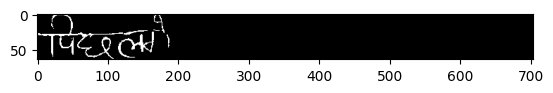

/opt/conda/lib/python3.11/site-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)
                                                                                                                        

--- Epoch 1 Training Finished. Average Loss: 0.4961 ---


Epoch 1 Validation:   0%|                                                       | 0/313 [00:00<?, ?batch/s, loss=0.0311]


--- Validation Batch 0 Samples ---


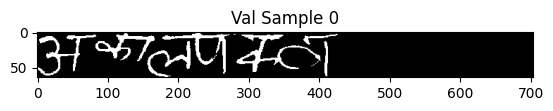

  True Label:    'अकालपक्व'
  Predicted Label: 'अकालपक्व'
--------------------


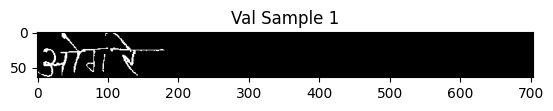

Epoch 1 Validation:   0%|▏                                              | 1/313 [00:00<02:47,  1.86batch/s, loss=0.0068]

  True Label:    'ओगरे'
  Predicted Label: 'ओगरे'
--------------------
--- End Validation Batch 0 Samples ---



--- Validation Epoch 1: Avg Loss: 0.0159, CER: 0.0034, WER: 0.0204 ---

===== Starting Epoch 2/50 =====


Epoch 2 Training:   0%|                                                                     | 0/2813 [00:00<?, ?batch/s]

Train Label: दिखाकर


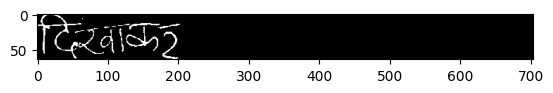

--- Epoch 2 Training Finished. Average Loss: 0.0112 ---


Epoch 2 Validation:   0%|                                                       | 0/313 [00:00<?, ?batch/s, loss=0.0021]


--- Validation Batch 0 Samples ---


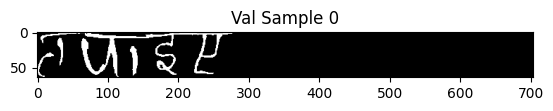

  True Label:    'तपाइए'
  Predicted Label: 'तपाइए'
--------------------


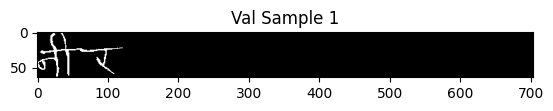

Epoch 2 Validation:   0%|▏                                              | 1/313 [00:00<02:41,  1.94batch/s, loss=0.0035]

  True Label:    'नीर'
  Predicted Label: 'नीर'
--------------------
--- End Validation Batch 0 Samples ---



--- Validation Epoch 2: Avg Loss: 0.0127, CER: 0.0043, WER: 0.0255 ---

===== Starting Epoch 3/50 =====


Epoch 3 Training:   0%|                                                                     | 0/2813 [00:00<?, ?batch/s]

Train Label: कुमुदिनीपति


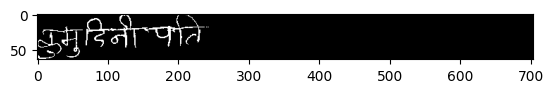

--- Epoch 3 Training Finished. Average Loss: 0.0070 ---


Epoch 3 Validation:   0%|                                                       | 0/313 [00:00<?, ?batch/s, loss=0.0095]


--- Validation Batch 0 Samples ---


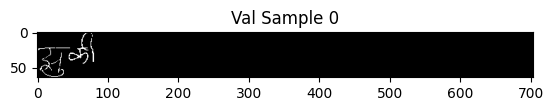

  True Label:    'झुकी'
  Predicted Label: 'झुकी'
--------------------


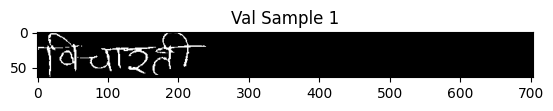

Epoch 3 Validation:   0%|▏                                              | 1/313 [00:00<02:41,  1.94batch/s, loss=0.0247]

  True Label:    'विचारती'
  Predicted Label: 'विचारती'
--------------------
--- End Validation Batch 0 Samples ---



--- Validation Epoch 3: Avg Loss: 0.0188, CER: 0.0030, WER: 0.0182 ---

===== Starting Epoch 4/50 =====


Epoch 4 Training:   0%|                                                                     | 0/2813 [00:00<?, ?batch/s]

Train Label: क्लमल


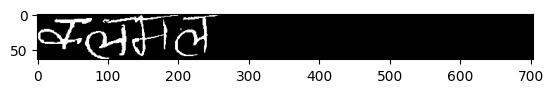

--- Epoch 4 Training Finished. Average Loss: 0.0057 ---


Epoch 4 Validation:   0%|                                                       | 0/313 [00:00<?, ?batch/s, loss=0.0009]


--- Validation Batch 0 Samples ---


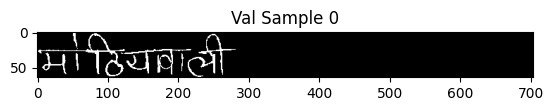

  True Label:    'मोठियावाली'
  Predicted Label: 'मोठियावाली'
--------------------


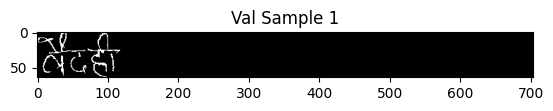

Epoch 4 Validation:   0%|▏                                              | 1/313 [00:00<02:43,  1.91batch/s, loss=0.0005]

  True Label:    'वैदही'
  Predicted Label: 'वैदही'
--------------------
--- End Validation Batch 0 Samples ---



--- Validation Epoch 4: Avg Loss: 0.0028, CER: 0.0006, WER: 0.0036 ---

===== Starting Epoch 5/50 =====


Epoch 5 Training:   0%|                                                                     | 0/2813 [00:00<?, ?batch/s]

Train Label: मणिपुरवासिनी


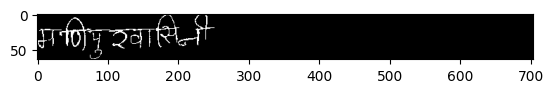

--- Epoch 5 Training Finished. Average Loss: 0.0047 ---


Epoch 5 Validation:   0%|                                                       | 0/313 [00:00<?, ?batch/s, loss=0.0051]


--- Validation Batch 0 Samples ---


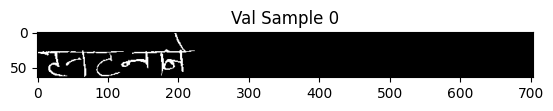

  True Label:    'टनटनाने'
  Predicted Label: 'टनटनाने'
--------------------


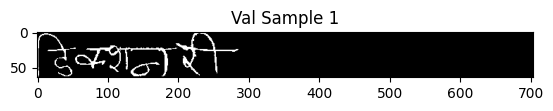

Epoch 5 Validation:   0%|▏                                              | 1/313 [00:00<02:43,  1.90batch/s, loss=0.0004]

  True Label:    'डिक्शनरी'
  Predicted Label: 'डिक्शनरी'
--------------------
--- End Validation Batch 0 Samples ---



--- Validation Epoch 5: Avg Loss: 0.0059, CER: 0.0016, WER: 0.0097 ---
Checkpoint saved to ./checkpoints/hindi_ocr_crnn/model_epoch_5.pth

===== Starting Epoch 6/50 =====


Epoch 6 Training:   0%|                                                                     | 0/2813 [00:00<?, ?batch/s]

Train Label: जतलवाए


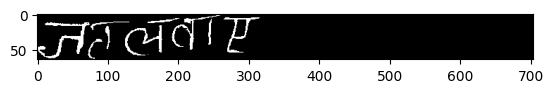

KeyboardInterrupt: 

In [21]:
from tqdm import tqdm # Force standard console version
print("\nStarting Training...")

for epoch in range(opt.epochs):
    print(f"\n===== Starting Epoch {epoch+1}/{opt.epochs} =====") # Add separator

    # --- Training Phase ---
    model.train()
    epoch_loss = 0.0
    processed_batches_train = 0

    # Use 'with' statement for automatic closing, matching the working example
    # Use leave=False, matching the working example (bar disappears after loop)
    with tqdm(enumerate(train_loader),
              total=len(train_loader),
              desc=f"Epoch {epoch+1} Training",
              leave=False, # Bar disappears after loop
              unit="batch") as batch_pbar: # Assign the tqdm object to batch_pbar

        for i, (words, sizes, chunks) in batch_pbar:
            # Prepare data
            images = chunks.to(device, non_blocking=True)
            num_chunks = images.shape[1]
            images = torch.cat([images[:, c_idx] for c_idx in range(num_chunks)], dim=2).unsqueeze(1)
            labels_str = [l.decode('utf-8') if isinstance(l, bytes) else l for l in words[0]]

            if not labels_str or images.numel() == 0:
                 # Use tqdm.write to avoid breaking the bar display
                 tqdm.write(f"Warning (Train Batch {i}): Empty batch data/image. Skipping.")
                 continue

            encoded_texts, text_lengths = converter.encode(labels_str)
            encoded_texts = encoded_texts.to(device)
            text_lengths = text_lengths.to(device)

            # Zero gradients
            optimizer.zero_grad(set_to_none=True)

            # Inside the training loop (temporarily)
            if i < 1: # Show first 5 batches
                import matplotlib.pyplot as plt
                plt.imshow(images[0].squeeze().cpu().numpy(), cmap='gray') # Adjust indexing/squeeze as needed
                print(f"Train Label: {labels_str[0]}")
                plt.show()
            # Do similarly in the validation loop

            # Forward pass
            try:
                outputs = model(images) # [W, B, C]
            except Exception as e:
                tqdm.write(f"Error during forward pass (Train Batch {i}): {e}. Skipping.")
                continue

            # Prepare for CTC loss
            seq_len, batch_size_actual, _ = outputs.shape
            if batch_size_actual != len(labels_str):
                 tqdm.write(f"Warning (Train Batch {i}): Batch size mismatch! Model B={batch_size_actual}, Labels B={len(labels_str)}. Skipping.")
                 continue
            input_lengths = torch.full(size=(batch_size_actual,), fill_value=seq_len, dtype=torch.long, device=device)
            log_probs = F.log_softmax(outputs, dim=2)

            # Calculate loss (add robust error handling)
            try:
                # Pre-checks for CTC
                if torch.any(text_lengths <= 0):
                     tqdm.write(f"Warning (Train Batch {i}): Invalid target length <=0. Skipping loss calc.")
                     continue
                if encoded_texts.shape[0] != text_lengths.sum():
                     tqdm.write(f"Warning (Train Batch {i}): Encoded text length ({encoded_texts.shape[0]}) != sum(text_lengths) ({text_lengths.sum()}). Skipping loss calc.")
                     continue
                if torch.any(input_lengths <= text_lengths):
                     problem_indices = torch.where(input_lengths <= text_lengths)[0]
                     tqdm.write(f"Warning (Train Batch {i}): Input length <= Target length for indices {problem_indices.tolist()}. Input: {input_lengths[problem_indices]}, Target: {text_lengths[problem_indices]}. Skipping loss calc.")
                     continue

                loss = criterion(log_probs, encoded_texts, input_lengths, text_lengths)

                if torch.isnan(loss) or torch.isinf(loss):
                    tqdm.write(f"Warning (Train Batch {i}): NaN or Inf loss detected ({loss.item()}). Skipping backward.")
                    continue

                # Backward pass and optimization
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
                optimizer.step()

                current_loss = loss.item()
                epoch_loss += current_loss
                processed_batches_train += 1 # Count successful batches
                # Update postfix using the tqdm object from the 'with' statement
                batch_pbar.set_postfix(loss=f"{current_loss:.4f}", refresh=True) # Use refresh=True for console updates

            except RuntimeError as e:
                 if "targets must be shorter than inputs" in str(e):
                      tqdm.write(f"CTC Runtime Error (Train Batch {i}): Targets longer than inputs. InputL={input_lengths.tolist()}, TargetL={text_lengths.tolist()}. Skipping batch.")
                 else:
                      tqdm.write(f"Runtime Error during training loss/backward (Batch {i}): {e}. Skipping batch.")
                 optimizer.zero_grad(set_to_none=True)
                 continue
            except Exception as e:
                 tqdm.write(f"Generic Error during training loss/backward (Batch {i}): {e}. Skipping batch.")
                 optimizer.zero_grad(set_to_none=True)
                 continue
        # End of training 'with' block (batch_pbar is automatically closed)

    # --- Training Epoch Finished ---
    # Calculate average loss based on successfully processed batches
    avg_epoch_loss = epoch_loss / processed_batches_train if processed_batches_train > 0 else 0.0
    # Print summary AFTER the training progress bar is gone
    print(f"--- Epoch {epoch+1} Training Finished. Average Loss: {avg_epoch_loss:.4f} ---")

    # Update learning rate scheduler (if used after training epoch)
    # scheduler.step()

    # --- Validation Phase ---
    model.eval() # Set model to evaluation mode
    val_loss = 0.0
    all_preds = []
    all_labels = []
    processed_batches_val = 0

    # Use 'with' statement for validation loop
    with tqdm(enumerate(val_loader),
              total=len(val_loader),
              desc=f"Epoch {epoch+1} Validation",
              leave=False, # Bar disappears after loop
              unit="batch") as val_pbar: # Assign tqdm object to val_pbar

        with torch.no_grad(): # Disable gradient calculations for validation
            for i_val, (words_val, sizes_val, chunks_val) in val_pbar:
                # Prepare validation data
                images_val = chunks_val.to(device, non_blocking=True)
                num_chunks_val = images_val.shape[1]
                images_val = torch.cat([images_val[:, c_idx] for c_idx in range(num_chunks_val)], dim=2).unsqueeze(1)
                labels_val_str = [l.decode('utf-8') if isinstance(l, bytes) else l for l in words_val[0]]

                if not labels_val_str or images_val.numel() == 0:
                    tqdm.write(f"Warning (Val Batch {i_val}): Empty labels or image data. Skipping.")
                    continue

                encoded_texts_val, text_lengths_val = converter.encode(labels_val_str)
                encoded_texts_val = encoded_texts_val.to(device)
                text_lengths_val = text_lengths_val.to(device)

                # Forward pass
                try:
                     outputs_val = model(images_val) # [W, B, C]
                except Exception as e:
                     tqdm.write(f"Error during forward pass (Val Batch {i_val}): {e}. Skipping.")
                     continue

                seq_len_val, bs_val, _ = outputs_val.shape
                if bs_val != len(labels_val_str):
                    tqdm.write(f"Warning (Val Batch {i_val}): Batch size mismatch! Model B={bs_val}, Labels B={len(labels_val_str)}. Skipping.")
                    continue
                input_lengths_val = torch.full(size=(bs_val,), fill_value=seq_len_val, dtype=torch.long, device=device)
                log_probs_val = F.log_softmax(outputs_val, dim=2)

                # Calculate validation loss
                current_val_loss = None
                try:
                    # Pre-checks similar to training
                    if torch.any(text_lengths_val <= 0):
                         tqdm.write(f"Warning (Val Batch {i_val}): Invalid target length <=0. Skipping loss.")
                    elif encoded_texts_val.shape[0] != text_lengths_val.sum():
                         tqdm.write(f"Warning (Val Batch {i_val}): Encoded text length != sum(text_lengths). Skipping loss.")
                    elif torch.any(input_lengths_val <= text_lengths_val):
                         problem_indices_val = torch.where(input_lengths_val <= text_lengths_val)[0]
                         tqdm.write(f"Warning (Val Batch {i_val}): Input length <= Target length for indices {problem_indices_val.tolist()}. Skipping loss.")
                    else:
                        loss_val_tensor = criterion(log_probs_val, encoded_texts_val, input_lengths_val, text_lengths_val)
                        if not torch.isnan(loss_val_tensor) and not torch.isinf(loss_val_tensor):
                            current_val_loss = loss_val_tensor.item()
                            val_loss += current_val_loss
                            processed_batches_val += 1 # Count successful validation batches
                        else:
                            tqdm.write(f"Warning (Val Batch {i_val}): NaN/Inf validation loss detected.")

                except RuntimeError as e:
                     tqdm.write(f"Runtime Error during validation loss (Batch {i_val}): {e}. Skipping loss for batch.")
                except Exception as e:
                     tqdm.write(f"Generic Error during validation loss (Batch {i_val}): {e}. Skipping loss for batch.")

                # Update validation postfix (using the tqdm object 'val_pbar')
                val_pbar.set_postfix(loss=f"{current_val_loss:.4f}" if current_val_loss is not None else "N/A", refresh=True)

                # Decode predictions for metrics
                try:
                    decoded_val = decode_predictions(outputs_val, converter)
                    all_preds.extend(decoded_val)
                    all_labels.extend(labels_val_str)

                    if i_val == 0: # Only show for the first validation batch each epoch
                        print("\n--- Validation Batch 0 Samples ---")
                        # Determine how many samples to show (e.g., first 5 or min(5, bs_val))
                        num_samples_to_show = min(2, bs_val)
                        for j in range(num_samples_to_show):
                            try:
                                plt.imshow(images_val[j].squeeze().cpu().numpy(), cmap='gray') # Use images_val[j]
                                plt.title(f"Val Sample {j}") # Generic title
                                plt.show() # Display the image
    
                                # Print corresponding labels and predictions from the CURRENT batch
                                print(f"  True Label:    '{labels_val_str[j]}'")
                                print(f"  Predicted Label: '{decoded_val[j]}'")
                                print("-" * 20)
    
                            except IndexError:
                                 print(f"Warning: Tried to display sample {j}, but batch size might be smaller.")
                                 break # Stop if we run out of samples in the batch
                            except Exception as display_e:
                                print(f"Error displaying validation sample {j}: {display_e}")
                        print("--- End Validation Batch 0 Samples ---\n")

                except Exception as e:
                    tqdm.write(f"Error during decoding (Val Batch {i_val}): {e}. Skipping metrics for batch.")
            # End of validation loop body
        # End of validation 'with torch.no_grad()' block
    # End of validation 'with tqdm(...)' block (val_pbar is automatically closed)

    # --- Validation Epoch Finished ---
    avg_val_loss = val_loss / processed_batches_val if processed_batches_val > 0 else 0.0
    val_cer, val_wer = -1.0, -1.0 # Default values
    if all_preds and all_labels:
        try:
            val_cer = calculate_cer(all_preds, all_labels)
            val_wer = calculate_wer(all_preds, all_labels)
        except Exception as e:
            tqdm.write(f"Error calculating CER/WER: {e}")
    elif not all_labels and processed_batches_val > 0 : # Check if validation ran but labels were missing
         tqdm.write("Warning: No labels collected during validation, cannot calculate CER/WER.")
    elif processed_batches_val == 0:
         tqdm.write("Warning: No batches successfully processed during validation.")
    else: # Labels exist, but preds failed/missing
         tqdm.write("Warning: No predictions generated/collected during validation, cannot calculate CER/WER.")

    # Print validation summary AFTER the validation progress bar is gone
    print(f"--- Validation Epoch {epoch+1}: Avg Loss: {avg_val_loss:.4f}, CER: {val_cer:.4f}, WER: {val_wer:.4f} ---")

    # --- End of Epoch ---
    model.train() # Set model back to training mode for the next epoch

    # --- Save Checkpoint ---
    if (epoch + 1) % 5 == 0 or epoch == opt.epochs - 1:
        checkpoint_path = os.path.join(opt.checkpoint_dir, opt.experiment_name)
        os.makedirs(checkpoint_path, exist_ok=True)
        save_path = os.path.join(checkpoint_path, f'model_epoch_{epoch+1}.pth')
        try:
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_loss': avg_epoch_loss,
                'val_loss': avg_val_loss,
                'val_cer': val_cer,
                'val_wer': val_wer,
                'opt': vars(opt)
            }, save_path)
            # Use standard print for checkpoint saving message, as bars are gone
            print(f"Checkpoint saved to {save_path}")
        except Exception as e:
            print(f"Error saving checkpoint: {e}") # Use standard print here too

print("\nTraining Finished.")